# 제품 이상여부 판별 프로젝트
- v7부터 창우님께서 결측값 engineering 해주신 train, test dataset 이용
https://data-minggeul.tistory.com/10?category=901822
- 위에 고려해서 실험
- 각 전처리 후 EDA해서 상관관계 높아지는 지 파악 및 정리
- 파생변수부터 만들기

## 필요한 라이브러리 설치

- AutoML 라이브러리, 모든 ML을 제공하는 full package로 설치

In [54]:
!pip install pycaret[full]

Defaulting to user installation because normal site-packages is not writeable


# 1. 데이터 불러오기


## 필수 라이브러리


In [34]:
import os
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore') # Suppresas warnings

## 데이터 읽어오기

In [35]:
RANDOM_STATE = 110

# Load data
train_df = pd.read_csv("train_pre.csv")
test_df = pd.read_csv("test_pre.csv")

In [36]:
# 필요없는 컬럼 삭제
test_df = test_df.drop(['Set ID', 'target'], axis=1)

In [147]:
train_df

,Unnamed: 0,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,...,127,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
1,1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,...,73,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
3,3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,...,197,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40503,40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,...,27,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40504,40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


# 2. 데이터 전처리

## (선택) 결측치 1차 처리
### 상황1. SKIP : 엔지니어링된 데이터셋 사용
### 상황2. 필수 : 초기 주어진 데이터셋 사용
> 이미 해당 코드를 수행하여 저장된 df를 사용중이면 skip

- 밀린 데이터를 한 칸씩 옮겨서 원상복구
- 완성된 df를 저장하기
- 해당 코드는 최초 1번만 수행하고 저장된 df를 불러와서 재사용하면 됨

### 'OK'값을 결측값으로 처리

In [58]:
# X좌표의 "OK"를 NaN으로 변환

columns_to_replace_ok = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
]

# Train 데이터셋에서 "OK" 값을 NaN으로 변경
for column in columns_to_replace_ok:
    train_df[column] = train_df[column].replace('OK', np.nan).astype(float)

# Test 데이터셋에서 "OK" 값을 NaN으로 변경
for column in columns_to_replace_ok:
    test_df[column] = test_df[column].replace('OK', np.nan).astype(float)

### 밀린 데이터를 원상복구

In [59]:
def shift_and_fill(data, start_col, end_col, step):

    start_idx = data.columns.get_loc(start_col)

    end_idx = data.columns.get_loc(end_col)

    missing_indices = data[data[start_col].isnull()].index

    # 결측치가 있는 각 행에 대하여 처리
    for idx in missing_indices:
        current_idx = start_idx

        while current_idx <= end_idx - step:
            next_idx = current_idx + step
            data.iloc[idx, current_idx] = data.iloc[idx, next_idx]
            current_idx = next_idx

        data.iloc[idx, end_idx] = np.nan

In [60]:
#Dam
shift_and_fill(train_df, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'WorkMode Collect Result_Dam', 3)
shift_and_fill(test_df, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'WorkMode Collect Result_Dam', 3)
#Fill1
shift_and_fill(train_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
               'WorkMode Collect Result_Fill1', 3)
shift_and_fill(test_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
               'WorkMode Collect Result_Fill1', 3)

#Fill2
shift_and_fill(train_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
               'WorkMode Collect Result_Fill2', 3)
shift_and_fill(test_df, "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
               'WorkMode Collect Result_Fill2', 3)


In [ ]:
train_df.to_csv("ord_train.csv")

In [ ]:
test_df.to_csv("ord_test.csv")

In [ ]:
# 마지막 열 채워주기

# train_data
train_df['WorkMode Collect Result_Fill1'] = 7
train_df['WorkMode Collect Result_Dam'] = 7
train_df['WorkMode Collect Result_Fill2'] = 0

# test_data
test_df['WorkMode Collect Result_Fill1'] = 7
test_df['WorkMode Collect Result_Dam'] = 7
test_df['WorkMode Collect Result_Fill2'] = 0


### 저장

In [ ]:
# 저장
SAVE_DIR = '/content/drive/MyDrive/aimers' # 코랩
train_df.to_csv(os.path.join(SAVE_DIR, "train.csv"), index=False)
test_df.to_csv(os.path.join(SAVE_DIR, "test.csv"), index=False)

## (필수) 결측치 2차 처리
- 모든 값이 결측치인 column 삭제
- 필요없는 column을 삭제하는 거라서 train, test 모두 적용 가능

In [70]:
# 현주님 파생변수
for df in [train_data, test_data]:
    df['1st Pressure*Time'] = np.round(df['1st Pressure Collect Result_AutoClave']*df['1st Pressure 1st Pressure Unit Time_AutoClave'],2)
    df['2nd Pressure*Time'] = np.round(df['2nd Pressure Collect Result_AutoClave']*df['2nd Pressure Unit Time_AutoClave'],2)
    df['3rd Pressure*Time'] = np.round(df['3rd Pressure Collect Result_AutoClave']*df['3rd Pressure Unit Time_AutoClave'],2)
    #df['Sum Pressure*Time'] = df['1st Pressure*Time']+df['2nd Pressure*Time']+df['3rd Pressure*Time'] -> 2랑 똑같은 상관계수
    df['Mean Pressure'] = df[['1st Pressure Collect Result_AutoClave', '2nd Pressure Collect Result_AutoClave', '3rd Pressure Collect Result_AutoClave']].mean(axis=1)
    ## tmp로 judge value 예측
    df['Predicted Chamber Temp. Judge Value'] = (df['Chamber Temp. Collect Result_AutoClave'] >= 49).astype(int)


NameError: name 'train_data' is not defined

In [ ]:
## 중앙값과 거리
features = ['1st Pressure Collect Result_AutoClave',
            '2nd Pressure Collect Result_AutoClave',
            '3rd Pressure Collect Result_AutoClave',
            '1st Pressure 1st Pressure Unit Time_AutoClave',
            '2nd Pressure Unit Time_AutoClave',
            '3rd Pressure Unit Time_AutoClave',
            'Chamber Temp. Collect Result_AutoClave',
            'Chamber Temp. Unit Time_AutoClave',
            'Machine Tact time Collect Result_Dam',
            'Machine Tact time Collect Result_Fill1',
            'Machine Tact time Collect Result_Fill2']
for df in [train_data,test_data]:
    for feature in features:
        # 새로운 피쳐 생성 (중앙값과의 거리)
        feature_name = f'Medain Distance {feature}'
        df[feature_name] = abs(df[feature] - df[feature].median())



In [37]:
# 모든 값이 결측값인 컬럼을 제거하는 함수
def remove_all_missing_columns(data):
    # 결측값이 모든 행에 있는 컬럼만 True로 표시됩니다.
    is_all_missing = data.isnull().all()
    # True가 아닌 컬럼만 선택하여 데이터프레임을 새로 생성합니다.
    cleaned_data = data.loc[:, ~is_all_missing]
    return cleaned_data

# train_data와 test_data에 함수 적용
train_df = remove_all_missing_columns(train_df)
test_df = remove_all_missing_columns(test_df)

In [38]:
# 'AutoClave'이 포함된 컬럼과 'target' 컬럼을 선택하여 데이터프레임 업데이트
train_df = train_df.loc[:, train_df.columns.str.contains('AutoClave') | (train_df.columns == 'target')]
test_df = test_df.loc[:, test_df.columns.str.contains('AutoClave')]

# 결과 확인
print("Updated train_df columns:")
print(train_df.columns)
print("\nUpdated test_df columns:")
print(test_df.columns)

Updated train_df columns:
Index(['Wip Line_AutoClave', 'Process Desc._AutoClave', 'Equipment_AutoClave',
       'Model.Suffix_AutoClave', 'Workorder_AutoClave',
       'Insp. Seq No._AutoClave', 'Insp Judge Code_AutoClave',
       '1st Pressure Collect Result_AutoClave',
       '1st Pressure 1st Pressure Unit Time_AutoClave',
       '1st Pressure Judge Value_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '2nd Pressure Judge Value_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       '3rd Pressure Judge Value_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave', 'target'],
      dtype='object')

Updated test_df columns:
Index(['Wip Line_AutoClave', 'Proc

In [73]:
# OK값이 있는 컬럼 중 필요없는 컬럼 제거
columns_to_remove = [
    "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam",
    "GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave",
    "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1",
    "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2"
]

# train_data에서 컬럼 제거
train_df.drop(columns=columns_to_remove, errors='ignore', inplace=True)

# test_data에서 컬럼 제거
test_df.drop(columns=columns_to_remove, errors='ignore', inplace=True)


### 결측치 시각화
- 확실히 창우님께서 엔지니어링해주신 dataset을 이용하니깐 결측치가 없어짐

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_missing_values(df):
  plt.figure(figsize=(24, 6))

  missing_counts = df.isna().sum()
  missing_counts.plot(kind='bar', color='skyblue')

  plt.title('Missing Values Count per Column')
  plt.xlabel('Columns')
  plt.ylabel('Number of Missing Values')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

In [ ]:
dam_columns = [col for col in train_df.columns if col.endswith('_Dam')]
train_df_dam = train_df[dam_columns]

aclave_columns = [col for col in train_df.columns if col.endswith('_AutoClave')]
train_df_aclave = train_df[aclave_columns]

fill1_columns = [col for col in train_df.columns if col.endswith('_Fill1')]
train_df_fill1 = train_df[fill1_columns]

fill2_columns = [col for col in train_df.columns if col.endswith('_Fill2')]
train_df_fill2 = train_df[fill2_columns]

In [ ]:
plot_missing_values(train_df_dam)
plot_missing_values(train_df_aclave)
plot_missing_values(train_df_fill1)
plot_missing_values(train_df_fill2)

In [ ]:
dam_columns = [col for col in test_df.columns if col.endswith('_Dam')]
test_df_dam = test_df[dam_columns]

aclave_columns = [col for col in test_df.columns if col.endswith('_AutoClave')]
test_df_aclave = test_df[aclave_columns]

fill1_columns = [col for col in test_df.columns if col.endswith('_Fill1')]
test_df_fill1 = test_df[fill1_columns]

fill2_columns = [col for col in test_df.columns if col.endswith('_Fill2')]
test_df_fill2 = test_df[fill2_columns]

In [ ]:
plot_missing_values(test_df_dam)
plot_missing_values(test_df_aclave)
plot_missing_values(test_df_fill1)
plot_missing_values(test_df_fill2)

## (필수) unique data가 1개인 컬럼 삭제
- 모든 rows에 동일한 값만 들어있는 column은 분류에 아무 영향을 안 줌

### 모든 컬럼에 대한 unique data 개수 출력

In [39]:
# "OK" 값을 1로 변경
train_df['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace('OK', 1, inplace=True)
test_df['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace('OK', 1, inplace=True)

# 결측값을 0으로 채우기
train_df['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(0, inplace=True)
test_df['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(0, inplace=True)

In [38]:
unique_counts = train_df.nunique()

### unique data가 1개인 컬럼 출력

In [7]:
unique_counts = train_df.nunique()
tr_cols_to_drop = unique_counts[unique_counts <= 1].index

# 검증: unique data의 개수 출력
unique_counts = train_df[tr_cols_to_drop].nunique()

In [8]:
# unique data가 1개 이하만 들어있는 컬럼
unique_counts = test_df.nunique()
te_cols_to_drop = unique_counts[unique_counts <= 1].index

# 검증: unique data의 개수 출력
unique_counts = test_df[te_cols_to_drop].nunique()

### unique data가 1개 이하인 컬럼 삭제

In [9]:
# 결과 출력
print("삭제 전 columns 개수 출력:")
print(len(train_df.columns))
print(len(test_df.columns))

# 1개 이하만 들어있는 컬럼 삭제
train_df = train_df.drop(columns=tr_cols_to_drop)
test_df  = test_df.drop(columns=te_cols_to_drop)

# 결과 출력
print("삭제 후 columns 개수 출력:")
print(len(train_df.columns))
print(len(test_df.columns))

삭제 전 columns 개수 출력:
22
21
삭제 후 columns 개수 출력:
13
12


In [10]:
train_df

,Model.Suffix_AutoClave,Workorder_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,target
0,AJX75334505,4F1XA938-1,0.312,240,0.493,1,0.499,120,54,361,OK,0.0,Normal
1,AJX75334505,3KPM0016-2,0.311,241,0.311,121,0.498,121,54,483,OK,0.0,Normal
2,AJX75334501,4E1X9167-1,0.315,241,0.490,1,0.498,121,56,363,OK,1.0,Normal
3,AJX75334501,3K1X0057-1,0.299,241,0.300,121,0.500,121,54,483,OK,0.0,Normal
4,AJX75334501,3HPM0007-1,0.302,240,0.302,120,0.498,120,47,480,NG,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,AJX75334501,3J1XF434-2,0.300,241,0.300,121,0.500,121,54,483,OK,0.0,Normal
40502,AJX75334501,4E1XC796-1,0.305,240,0.493,1,0.498,120,49,361,NG,0.0,Normal
40503,AJX75334501,4C1XD438-1,0.309,241,0.490,1,0.498,121,48,363,NG,1.0,Normal
40504,AJX75334501,3I1XA258-1,0.302,241,0.303,121,0.499,121,54,483,OK,0.0,Normal


## 동일해야하는 변수 찾고 제거하기

In [27]:
# Equipment_Dam 컬럼에서 #1을 포함하는 값은 0으로, #2를 포함하는 값은 1로 변환
def convert_equipment_values(row):
    if '#1' in str(row):
        return 0
    elif '#2' in str(row):
        return 1
    return row  # #1 또는 #2를 포함하지 않는 경우 원래 값 유지

train_df['Equipment_Dam'] = train_df['Equipment_Dam'].apply(convert_equipment_values)
train_df['Equipment_Fill1'] = train_df['Equipment_Fill1'].apply(convert_equipment_values)
train_df['Equipment_Fill2'] = train_df['Equipment_Fill2'].apply(convert_equipment_values)

test_df['Equipment_Dam'] = test_df['Equipment_Dam'].apply(convert_equipment_values)
test_df['Equipment_Fill1'] = test_df['Equipment_Fill1'].apply(convert_equipment_values)
test_df['Equipment_Fill2'] = test_df['Equipment_Fill2'].apply(convert_equipment_values)

In [28]:
# 컬럼 그룹 정의
equipment_cols = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2']
model_suffix_cols = [col for col in train_df.columns if "Model.Suffix" in col]
workorder_cols = [col for col in train_df.columns if "Workorder" in col]
receip_no_cols = [col for col in train_df.columns if "Receip No Collect Result" in col]
pallet_id_cols = [col for col in train_df.columns if "PalletID" in col]
production_qty_cols = [col for col in train_df.columns if "Production" in col]

# 주어진 컬럼 그룹에서 서로 다른 값을 찾는 함수
def find_differences(data, columns):
    if not columns:
        return None  # 주어진 컬럼 그룹이 비어있는 경우 None 반환
    comparison_df = data[columns]
    diff_rows = comparison_df[comparison_df.nunique(axis=1) > 1]  # 행별로 유일한 값의 수를 계산, 1보다 크면 다름
    return diff_rows

# 데이터에 대한 일관성 검사 실행
def check_consistency(data, columns_groups):
    results = {}
    for key, cols in columns_groups.items():
        results[key] = find_differences(data, cols)
        print(f"Differences in {key} columns:\n", results[key])

# 컬럼 그룹을 딕셔너리로 관리
columns_groups = {
    'Model Suffix': model_suffix_cols,
    'Workorder': workorder_cols,
    'Receip No': receip_no_cols,
    'Pallet ID': pallet_id_cols,
    'Production Qty': production_qty_cols,
    'Equipment': equipment_cols  # 추가된 그룹
}

# Train data와 Test data에 대해 일관성 검사 실행
print("Checking consistency in train_df:")
check_consistency(train_df, columns_groups)

Checking consistency in train_df:
Differences in Model Suffix columns:
 Empty DataFrame
Columns: [Model.Suffix_Dam, Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2]
Index: []
Differences in Workorder columns:
 Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []
Differences in Receip No columns:
        Receip No Collect Result_Dam  Receip No Collect Result_Fill1  \
2766                              1                               6   
8878                              1                               6   
37520                             1                               4   
37788                             1                               6   

       Receip No Collect Result_Fill2  
2766                                6  
8878                                6  
37520                               1  
37788                               6  
Differences in Pallet ID columns:
        PalletID Collect Result_Dam  PalletI

In [29]:
# 행 제거 함수
def remove_inconsistent_rows(data, columns_groups):
    for key, cols in columns_groups.items():
        diff_rows = find_differences(data, cols)
        if diff_rows is not None:
            data.drop(diff_rows.index, inplace=True)
    return data

train_df = remove_inconsistent_rows(train_df, columns_groups)

In [30]:
# 컬럼 그룹 정의
equipment_cols = ['Equipment_Dam', 'Equipment_Fill1', 'Equipment_Fill2']
model_suffix_cols = [col for col in test_df.columns if "Model.Suffix" in col]
workorder_cols = [col for col in test_df.columns if "Workorder" in col]
receip_no_cols = [col for col in test_df.columns if "Receip No Collect Result" in col]
pallet_id_cols = [col for col in test_df.columns if "PalletID" in col]
production_qty_cols = [col for col in test_df.columns if "Production" in col]

# 주어진 컬럼 그룹에서 서로 다른 값을 찾는 함수
def find_differences(data, columns):
    if not columns:
        return None  # 주어진 컬럼 그룹이 비어있는 경우 None 반환
    comparison_df = data[columns]
    diff_rows = comparison_df[comparison_df.nunique(axis=1) > 1]  # 행별로 유일한 값의 수를 계산, 1보다 크면 다름
    return diff_rows

# 데이터에 대한 일관성 검사 실행
def check_consistency(data, columns_groups):
    results = {}
    for key, cols in columns_groups.items():
        results[key] = find_differences(data, cols)
        print(f"Differences in {key} columns:\n", results[key])

# 컬럼 그룹을 딕셔너리로 관리
columns_groups = {
    'Model Suffix': model_suffix_cols,
    'Workorder': workorder_cols,
    'Receip No': receip_no_cols,
    'Pallet ID': pallet_id_cols,
    'Production Qty': production_qty_cols,
    'Equipment': equipment_cols  # 추가된 그룹
}

# Test data에 대해 일관성 검사 실행
print("Checking consistency in test_df:")
check_consistency(test_df, columns_groups)

Checking consistency in test_df:
Differences in Model Suffix columns:
 Empty DataFrame
Columns: [Model.Suffix_Dam, Model.Suffix_AutoClave, Model.Suffix_Fill1, Model.Suffix_Fill2]
Index: []
Differences in Workorder columns:
 Empty DataFrame
Columns: [Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2]
Index: []
Differences in Receip No columns:
 Empty DataFrame
Columns: [Receip No Collect Result_Dam, Receip No Collect Result_Fill1, Receip No Collect Result_Fill2]
Index: []
Differences in Pallet ID columns:
        PalletID Collect Result_Dam  PalletID Collect Result_Fill1  \
64                             5.0                            4.0   
562                           11.0                            8.0   
1460                           5.0                            5.0   
1530                          12.0                           12.0   
1892                           6.0                            6.0   
2505                           3.0                      

In [31]:
# 각 컬럼 그룹에서 불일치를 찾은 후, 중복 없이 모든 인덱스를 저장할 집합
unique_indices = set()

# 데이터에 대한 일관성 검사 실행 및 중복 없는 인덱스 수집
def check_and_collect_indices(data, columns_groups):
    for key, cols in columns_groups.items():
        if cols:  # 비어있지 않은 경우만 처리
            diff_rows = find_differences(data, cols)
            if diff_rows is not None:
                # 차이가 있는 행의 인덱스를 집합에 추가
                unique_indices.update(diff_rows.index)

# Test data에 대해 일관성 검사 실행
check_and_collect_indices(test_df, columns_groups)

# 중복 없는 인덱스 리스트 생성
unique_indices_list = sorted(list(unique_indices))  # 정렬된 리스트로 변환

print("Unique indices with inconsistencies:", unique_indices_list)

Unique indices with inconsistencies: [64, 562, 1460, 1530, 1892, 2505, 2710, 3457, 3682, 3732, 4928, 4932, 6092, 7001, 7287, 7666, 7836, 8253, 8898, 10989, 12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964]


In [32]:
# test_df 행 제거
test_df = remove_inconsistent_rows(test_df, columns_groups)

## 제거할 변수(모든 공정에서 동일해야하는 컬럼. => 동일하지 않은 컬럼은 제거 후 진행 해야함)
- Model.Suffix(DAM 제외)
- PalletID (DAM 제외)
- Workorder(DAM 제외)
- Production Qty(DAM제외)
- Receip No(DAM제외)

In [47]:
remove_cols = ['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2', 
               'Equipment_Fill1', 'Equipment_Fill2',
               'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2',
               'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2',
               'Production Qty Collect Result_Fill1', 'Production Qty Collect Result_Fill2',
               'PalletID Collect Result_Fill1','PalletID Collect Result_Fill2']

# 결과 출력
print("삭제 전 columns 개수 출력:")
print(len(train_df.columns))
print(len(test_df.columns))

# 삭제
train_df = train_df.drop(columns=remove_cols)
test_df  = test_df.drop(columns=remove_cols)

# 결과 출력
print("삭제 후 columns 개수 출력:")
print(len(train_df.columns))
print(len(test_df.columns))

삭제 전 columns 개수 출력:
121
120
삭제 후 columns 개수 출력:
107
106


In [48]:
train_df = train_df.drop(columns ="Unnamed: 0")

In [49]:
test_df = test_df.drop(columns = "Unnamed: 0")

## Equipment_Dam을 기준으로 0일때 unique 가 1개 and 1일때 unique가 1개인 컬럼은 제거

In [50]:
def remove_single_value_columns(df):
    # Equipment_Dam 값에 따른 데이터 분할
    group_0 = df[df['Equipment_Dam'] == 0]
    group_1 = df[df['Equipment_Dam'] == 1]

    # 유니크한 값이 1인 컬럼을 찾고 제거하는 함수
    def find_single_value_columns(data):
        columns_to_remove = []
        for col in data.columns:
            # Equipment_Dam 컬럼은 제외
            if col != 'Equipment_Dam' and len(data[col].unique()) == 1:
                columns_to_remove.append(col)
        return columns_to_remove

    # 각 그룹에 대해 유니크한 값이 1인 컬럼 찾기
    columns_to_remove_0 = find_single_value_columns(group_0)
    columns_to_remove_1 = find_single_value_columns(group_1)

    # 두 그룹에서 공통으로 제거할 컬럼 찾기
    common_columns_to_remove = list(set(columns_to_remove_0) & set(columns_to_remove_1))

    # 공통 컬럼 제거
    return df.drop(columns=common_columns_to_remove, inplace=False), common_columns_to_remove


In [51]:
# Train data와 Test data에서 일관성 없는 행 제거
train_df, train_removed_cols = remove_single_value_columns(train_df)
print("Removed columns from train_df:", train_removed_cols)

Removed columns from train_df: ['CURE START POSITION Θ Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2', 'CURE START POSITION X Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']


In [52]:
columns_to_remove = [
    'CURE START POSITION Θ Collect Result_Dam', 'CURE END POSITION X Collect Result_Dam', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2', 
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2', 
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2', 
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', 'CURE END POSITION Θ Collect Result_Dam', 
    'CURE START POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam'
]

# test_df에서 해당 컬럼들을 제거
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')



In [ ]:
print(len(train_df.columns))
print(len(test_df.columns))

In [53]:
# train_df와 test_df에서 컬럼 집합을 가져옵니다.
train_columns = set(train_df.columns)
test_columns = set(test_df.columns)

# train_df에는 있지만 test_df에는 없는 컬럼을 찾습니다.
only_in_train = train_columns.difference(test_columns)
print("Only in train_df:", only_in_train)

# test_df에는 있지만 train_df에는 없는 컬럼을 찾습니다.
only_in_test = test_columns.difference(train_columns)
print("Only in test_df:", only_in_test)

Only in train_df: {'target'}
Only in test_df: set()


# 제가 생각하기에 DAM에서 필요없는 컬럼(지금까지 제거된거 제외)


1. Distance Speed중 동일한 컬럼 제거.

In [54]:
# 제거할 컬럼 목록
columns_to_remove = [
    "Stage1 Circle2 Distance Speed Collect Result_Dam", 
    "Stage1 Circle3 Distance Speed Collect Result_Dam", 
    "Stage1 Circle4 Distance Speed Collect Result_Dam", 
    "Stage2 Circle2 Distance Speed Collect Result_Dam", 
    "Stage2 Circle3 Distance Speed Collect Result_Dam", 
    "Stage2 Circle4 Distance Speed Collect Result_Dam", 
    "Stage3 Circle2 Distance Speed Collect Result_Dam", 
    "Stage3 Circle3 Distance Speed Collect Result_Dam", 
    "Stage3 Circle4 Distance Speed Collect Result_Dam"
]

# train_df에서 컬럼 제거
train_df = train_df.drop(columns=columns_to_remove, errors='ignore')

# test_df에서 컬럼 제거
test_df = test_df.drop(columns=columns_to_remove, errors='ignore')



2. Chamber Temp. Judge Value_AutoClave 컬럼 0,1로 인코딩

In [55]:
train_df['Chamber Temp. Judge Value_AutoClave'] = train_df['Chamber Temp. Judge Value_AutoClave'].map({'OK': 1, 'NG': 0})
test_df['Chamber Temp. Judge Value_AutoClave'] = test_df['Chamber Temp. Judge Value_AutoClave'].map({'OK': 1, 'NG': 0})

In [126]:
train_df.columns

Index(['Equipment_Dam', 'Model.Suffix_Dam', 'Workorder_Dam',
       'CURE SPEED Collect Result_Dam',
       'DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
       'Dispense Volume(Stage1) Collect Result_Dam',
       'Dispense Volume(Stage2) Collect Result_Dam',
       'Dispense Volume(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE

## 내 맘대로 마구 제거


In [56]:
# 1. 노즐 좌표 제거 dam fill1, fill2
columns_to_remove=['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
       'Head Purge Position Z Collect Result_Fill1','CURE END POSITION X Collect Result_Fill2',
       'CURE END POSITION Z Collect Result_Fill2','CURE STANDBY POSITION Z Collect Result_Fill2',
       'CURE START POSITION X Collect Result_Fill2',
       'CURE START POSITION Z Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
       'Head Purge Position Z Collect Result_Fill2']


# train_df에서 컬럼 제거
train_df = train_df.drop(columns=columns_to_remove)

# test_df에서 컬럼 제거
test_df = test_df.drop(columns=columns_to_remove)



In [57]:
#2 공정시간제거
columns_to_remove=['Machine Tact time Collect Result_Dam','Machine Tact time Collect Result_Fill1','Machine Tact time Collect Result_Fill2']
# train_df에서 컬럼 제거
train_df = train_df.drop(columns=columns_to_remove)

# test_df에서 컬럼 제거
test_df = test_df.drop(columns=columns_to_remove)


In [193]:
columns_to_remove = ['DISCHARGED SPEED OF RESIN Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
       'Head Clean Position Z Collect Result_Dam',
       'Head Purge Position Z Collect Result_Dam',
       'Head Zero Position Y Collect Result_Dam',
       'Head Zero Position Z Collect Result_Dam','Stage1 Circle1 Distance Speed Collect Result_Dam',
       'Stage1 Line1 Distance Speed Collect Result_Dam',
       'Stage1 Line2 Distance Speed Collect Result_Dam',
       'Stage1 Line3 Distance Speed Collect Result_Dam',
       'Stage1 Line4 Distance Speed Collect Result_Dam',
       'Stage2 Circle1 Distance Speed Collect Result_Dam',
       'Stage2 Line1 Distance Speed Collect Result_Dam',
       'Stage2 Line2 Distance Speed Collect Result_Dam',
       'Stage2 Line3 Distance Speed Collect Result_Dam',
       'Stage2 Line4 Distance Speed Collect Result_Dam',
       'Stage3 Circle1 Distance Speed Collect Result_Dam',
       'Stage3 Line1 Distance Speed Collect Result_Dam',
       'Stage3 Line2 Distance Speed Collect Result_Dam',
       'Stage3 Line3 Distance Speed Collect Result_Dam',
       'Stage3 Line4 Distance Speed Collect Result_Dam','DISCHARGED SPEED OF RESIN Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
       'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
       'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
       'Head Purge Position Z Collect Result_Fill1','CURE END POSITION X Collect Result_Fill2',
       'CURE END POSITION Z Collect Result_Fill2', 'CURE STANDBY POSITION Z Collect Result_Fill2',
       'CURE START POSITION X Collect Result_Fill2',
       'CURE START POSITION Z Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
       'Head Purge Position Z Collect Result_Fill2'
]

# train_df에서 컬럼 제거
train_df = train_df.drop(columns=columns_to_remove)

# test_df에서 컬럼 제거
test_df = test_df.drop(columns=columns_to_remove)


In [11]:
train_df = train_df.drop(columns="Workorder_AutoClave")
test_df = test_df.drop(columns="Workorder_AutoClave")
train_df = train_df.drop(columns="Model.Suffix_AutoClave")
test_df = test_df.drop(columns="Model.Suffix_AutoClave")

In [197]:
train_df = train_df.drop(columns='Production Qty Collect Result_Dam')
test_df = test_df.drop(columns='Production Qty Collect Result_Dam')

In [12]:
# 값 분리 및 변환 함수
def split_and_separate(row):
    # '-'를 기준으로 문자열 분리
    parts = row.split('-')
    if len(parts) == 2:
        # 대시 이전 부분을 문자 단위로 분리
        before_dash = [char for char in parts[0]]
        # 대시 이후 부분은 전체를 하나의 값으로 처리
        after_dash = [parts[1]]
        return before_dash + after_dash
    else:
        # 분리된 부분이 예상과 다르면 오류 처리
        return [None] * (len(parts[0]) + 1)

# 적용 및 DataFrame 변환
max_length = train_df['Workorder_Dam'].apply(lambda x: len(x.split('-')[0]) + 1).max()
column_names = [f'char_{i+1}_Dam' for i in range(max_length - 1)] + ['after_dash_Dam']
df_transformed = pd.DataFrame(train_df['Workorder_Dam'].apply(split_and_separate).tolist(), columns=column_names)
train_df = pd.concat([train_df, df_transformed], axis=1)


KeyError: 'Workorder_Dam'

In [13]:
train_df.columns

Index(['1st Pressure Collect Result_AutoClave',
       '1st Pressure 1st Pressure Unit Time_AutoClave',
       '2nd Pressure Collect Result_AutoClave',
       '2nd Pressure Unit Time_AutoClave',
       '3rd Pressure Collect Result_AutoClave',
       '3rd Pressure Unit Time_AutoClave',
       'Chamber Temp. Collect Result_AutoClave',
       'Chamber Temp. Unit Time_AutoClave',
       'Chamber Temp. Judge Value_AutoClave',
       'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 'target'],
      dtype='object')

3. Model.Suffix_Dam 원-핫 인코딩(진행 X)

In [58]:
import pandas as pd

# 'Model.Suffix_Dam'에 대한 원-핫 인코딩 적용
train_dummies = pd.get_dummies(train_df['Model.Suffix_Dam'], prefix='ModelSuffixDam')
test_dummies = pd.get_dummies(test_df['Model.Suffix_Dam'], prefix='ModelSuffixDam')

# 원-핫 인코딩된 결과를 원본 데이터프레임에 결합
train_df = pd.concat([train_df, train_dummies], axis=1)
test_df = pd.concat([test_df, test_dummies], axis=1)

# 원본 'Model.Suffix_Dam' 컬럼 제거
train_df.drop('Model.Suffix_Dam', axis=1, inplace=True)
test_df.drop('Model.Suffix_Dam', axis=1, inplace=True)


In [59]:
# 'Receip No Collect Result_Dam'에 대한 원-핫 인코딩 적용
train_dummies = pd.get_dummies(train_df['Receip No Collect Result_Dam'], prefix='ReceipNo')
test_dummies = pd.get_dummies(test_df['Receip No Collect Result_Dam'], prefix='ReceipNo')

# 원-핫 인코딩된 결과를 원본 데이터프레임에 결합
train_df = pd.concat([train_df, train_dummies], axis=1)
test_df = pd.concat([test_df, test_dummies], axis=1)

# 원본 'Receip No Collect Result_Dam' 컬럼 제거
train_df.drop('Receip No Collect Result_Dam', axis=1, inplace=True)
test_df.drop('Receip No Collect Result_Dam', axis=1, inplace=True)

In [60]:
# 'PalletID Collect Result_Dam'에 대한 원-핫 인코딩 적용
train_dummies = pd.get_dummies(train_df['PalletID Collect Result_Dam'], prefix='PalletID')
test_dummies = pd.get_dummies(test_df['PalletID Collect Result_Dam'], prefix='PalletID')

# 원-핫 인코딩된 결과를 원본 데이터프레임에 결합
train_df = pd.concat([train_df, train_dummies], axis=1)
test_df = pd.concat([test_df, test_dummies], axis=1)

# 원본 'PalletID Collect Result_Dam' 컬럼 제거
train_df.drop('PalletID Collect Result_Dam', axis=1, inplace=True)
test_df.drop('PalletID Collect Result_Dam', axis=1, inplace=True)

먼저, 도포의 속도와 시간은 중요하지 않다고 생각한다. 결국에는 Volumn이 중요
1. "DISCHARGED SPEED OF RESIN Collect Result_Dam"
2. "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"
3. "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam"
4. "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam"


## 도메인지식 참고하여 의미없어보이는 컬럼 삭제
- Dam
  - CURE POSITION 전부
  - HEAD NORMAL 전부 (단, Stage1 Z AXIS만 남김)
  - DISCHARGED는 Stage1과 Stage3이 종속이라 Stage3 제거
  - Distance Speed는 Circle/Line 상관없이 Stage별 종속이라 Stage1, Stage2, Stage3 각각 하나만 남기고 삭제
- Fill1
  - HEAD NORMAL 전부 (단, Stage1 Z AXIS만 남김)
- Fill2
  - CURE POSITION X 전부 (POSITION Z와 SPEED는 남김)
  - HEAD NORMAL 전부



In [28]:
remove_cols = [
  'CURE END POSITION X Collect Result_Dam',
  'CURE END POSITION Z Collect Result_Dam',
  'CURE END POSITION Θ Collect Result_Dam',
  'CURE START POSITION X Collect Result_Dam',
  'CURE START POSITION Θ Collect Result_Dam',

  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',

  'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',

  'Stage1 Circle2 Distance Speed Collect Result_Dam',
  'Stage1 Circle3 Distance Speed Collect Result_Dam',
  'Stage1 Circle4 Distance Speed Collect Result_Dam',
  'Stage1 Line1 Distance Speed Collect Result_Dam',
  'Stage1 Line2 Distance Speed Collect Result_Dam',
  'Stage1 Line3 Distance Speed Collect Result_Dam',
  'Stage1 Line4 Distance Speed Collect Result_Dam',
  'Stage2 Circle2 Distance Speed Collect Result_Dam',
  'Stage2 Circle3 Distance Speed Collect Result_Dam',
  'Stage2 Circle4 Distance Speed Collect Result_Dam',
  'Stage2 Line1 Distance Speed Collect Result_Dam',
  'Stage2 Line2 Distance Speed Collect Result_Dam',
  'Stage2 Line3 Distance Speed Collect Result_Dam',
  'Stage2 Line4 Distance Speed Collect Result_Dam',
  'Stage3 Circle2 Distance Speed Collect Result_Dam',
  'Stage3 Circle3 Distance Speed Collect Result_Dam',
  'Stage3 Circle4 Distance Speed Collect Result_Dam',
  'Stage3 Line1 Distance Speed Collect Result_Dam',
  'Stage3 Line2 Distance Speed Collect Result_Dam',
  'Stage3 Line3 Distance Speed Collect Result_Dam',
  'Stage3 Line4 Distance Speed Collect Result_Dam',

  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',

  'CURE END POSITION X Collect Result_Fill2',
  'CURE SPEED Collect Result_Fill2',
  'CURE START POSITION X Collect Result_Fill2',

  'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
  'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 결과 출력
print("삭제 전 columns 개수 출력:")
print('Train DataFrame Columns:', len(train_df.columns))
print('Test DataFrame Columns:', len(test_df.columns))

# 실제 존재하는 컬럼만 필터링하여 제거
existing_cols_train = [col for col in remove_cols if col in train_df.columns]
existing_cols_test = [col for col in remove_cols if col in test_df.columns]

train_df = train_df.drop(columns=existing_cols_train)
test_df = test_df.drop(columns=existing_cols_test)

# 결과 출력
print("삭제 후 columns 개수 출력:")
print('Train DataFrame Columns:', len(train_df.columns))
print('Test DataFrame Columns:', len(test_df.columns))

삭제 전 columns 개수 출력:
Train DataFrame Columns: 110
Test DataFrame Columns: 109
삭제 후 columns 개수 출력:
Train DataFrame Columns: 76
Test DataFrame Columns: 75


- 최종 학습모델에 넣을 df 확인

In [35]:
train_df.columns.to_list()

['Equipment_Dam',
 'Model.Suffix_Dam',
 'Workorder_Dam',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'Production Qty Collect Result_Dam',
 'Stage1 Circle1 Distance Speed Collect Result_Dam',
 'Stage1 Line1 Distance Speed Collect Result_Dam',
 'Stage1 Line2 Distance Speed Collect Result_Dam',
 'Stage1 Line3 Distance Speed Collect Result_Dam',
 'Stage1 Line4 Distance Speed Collect Result_Dam',
 'Stage2 Circle1 Distance Speed Collect Result_Dam',
 'Stage2 Line1 Distance Speed Collect Result_Dam',
 'Stage2 Line2 Distance Speed Collect Result_Dam',
 'Stage2 Line3 Distance Speed Collect Result_Dam',
 'Stage2 Line4 Distance Speed Collect Result_Dam',

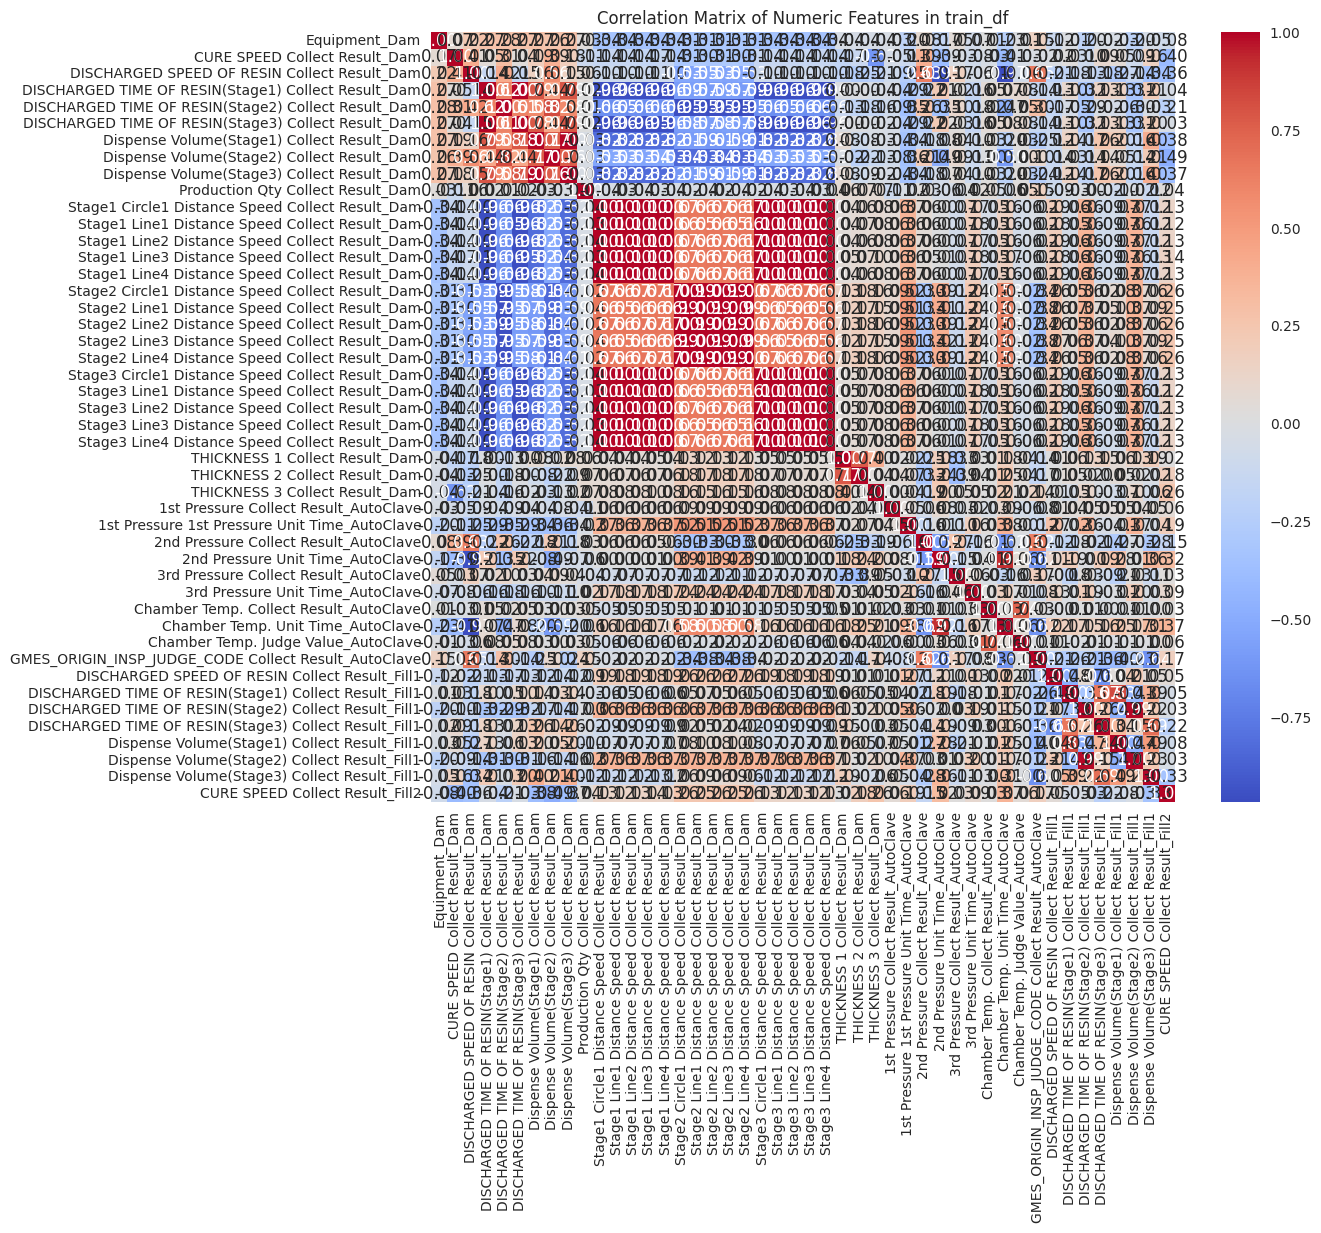

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# 수치형 변수만 선택
numeric_df = train_df.select_dtypes(include=['number'])

# 상관 계수 행렬 계산
correlation_matrix = numeric_df.corr()

# 히트맵으로 상관 계수 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features in train_df')
plt.show()

In [62]:
train_df.to_csv("train_al.csv")

In [23]:
# 각 열별 결측값의 개수 계산
train_df.isnull().sum()

Equipment_Dam                                                 0
Model.Suffix_Dam                                              0
Workorder_Dam                                                 0
CURE SPEED Collect Result_Dam                                 0
DISCHARGED SPEED OF RESIN Collect Result_Dam                  0
                                                             ..
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2    0
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2    0
Head Purge Position Z Collect Result_Fill2                    0
Machine Tact time Collect Result_Fill2                        0
target                                                        0
Length: 85, dtype: int64

- 상관분석

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_heatmap(df, triangle=False):
  df = df.copy()  # 원본 손상입히지않게 새로 반환

  # 범주형 변수들을 숫자로 변환: 레이블 인코딩
  le = LabelEncoder()
  for column in df.columns:
      if df[column].dtype == 'object':
          df[column] = le.fit_transform(df[column])

  # 상관계수 계산
  correlation_matrix = df.corr()

  # 상관행렬 출력
  #print("Correlation Matrix:")
  #print(correlation_matrix)

  # 상관행렬 시각화
  plt.figure(figsize=(60, 60)) # 크기를 크게 조정 가능

  # 삼각형으로 그리기
  if triangle == True:
    mask = np.triu(np.ones_like(correlation_matrix))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 12}, mask = mask) # 숫자 font size는 12로 함
  # 사각형으로 그리기
  else:
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 12}) # 숫자 font size는 12로 함

  plt.title('Correlation Matrix', fontsize=16)
  plt.show()

In [ ]:
plot_heatmap(train_df, triangle=False)

## 데이터 분할
- train, valid
- features, y

In [40]:
train_split_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["target"],
    random_state=RANDOM_STATE,
)


## 분포 비율 출력
def print_stats(df: pd.DataFrame):
    normal_num = len(df[df["target"] == "Normal"])
    abnormal_num = len(df[df["target"] == "AbNormal"])
    print(f"Normal: {normal_num}, AbNormal: {abnormal_num}" + f" ratio: {abnormal_num/normal_num}")

# Print statistics
print('Train Data Frame:')
print_stats(train_split_df)
print('Test Data Frame:')
print_stats(valid_df)

Train Data Frame:
Normal: 30524, AbNormal: 1880 ratio: 0.06159087930808544
Test Data Frame:
Normal: 7632, AbNormal: 470 ratio: 0.061582809224318656


In [41]:
y_train = train_split_df['target']
X_train = train_split_df.drop('target', axis=1)

# 결과 확인
print(X_train.shape)
print(y_train.value_counts())

(32404, 21)
target
Normal      30524
AbNormal     1880
Name: count, dtype: int64


In [42]:
y_valid = valid_df['target']
X_valid = valid_df.drop('target', axis=1)

# 결과 확인
print(X_valid.shape)
print(y_valid.value_counts())

(8102, 21)
target
Normal      7632
AbNormal     470
Name: count, dtype: int64


# 3. 모델 학습
- AutoML: pycaret full package 이용
- 앙상블러닝 중 soft voting 이용

In [43]:
clf = setup(data=X_train, target=y_train, session_id=RANDOM_STATE, n_jobs=4)
models = compare_models(sort = 'F1', n_select = 10)

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 22)"
5,Transformed data shape,"(32404, 28)"
6,Transformed train set shape,"(22682, 28)"
7,Transformed test set shape,"(9722, 28)"
8,Numeric features,10
9,Categorical features,11


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9403,0.6032,0.9403,0.9146,0.9195,0.1001,0.1474,0.1540
rf,Random Forest Classifier,0.9340,0.6440,0.9340,0.9110,0.9195,0.1445,0.1640,0.2300
catboost,CatBoost Classifier,0.9422,0.6464,0.9422,0.9198,0.9195,0.0871,0.1515,0.9980
xgboost,Extreme Gradient Boosting,0.9418,0.6462,0.9418,0.9190,0.9194,0.0891,0.1503,0.1480
lightgbm,Light Gradient Boosting Machine,0.9435,0.6546,0.9435,0.9321,0.9194,0.0785,0.1691,0.1310
gbc,Gradient Boosting Classifier,0.9438,0.6514,0.9438,0.9369,0.9193,0.0749,0.1744,0.6260
ada,Ada Boost Classifier,0.9423,0.6504,0.9423,0.9173,0.9158,0.0280,0.0815,0.2620
lr,Logistic Regression,0.9424,0.6580,0.9424,0.9318,0.9156,0.0258,0.0947,1.6080
lda,Linear Discriminant Analysis,0.9313,0.6509,0.9313,0.9041,0.9152,0.0914,0.1060,0.1090
ridge,Ridge Classifier,0.9420,0.6510,0.9420,0.8955,0.9141,0.0039,0.0153,0.1020


In [44]:
kfold = 10

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['rf','lightgbm','catboost', 'xgboost','gbc']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter =10, optimize = 'F1'))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9330,0.6430,0.9330,0.9088,0.9180,0.1285,0.1466
1,0.9361,0.6172,0.9361,0.9126,0.9205,0.1470,0.1726
2,0.9356,0.6593,0.9356,0.9146,0.9221,0.1710,0.1919
3,0.9321,0.6174,0.9321,0.9075,0.9173,0.1167,0.1322
4,0.9343,0.6615,0.9343,0.9119,0.9202,0.1497,0.1688
5,0.9343,0.6543,0.9343,0.9111,0.9197,0.1410,0.1606
6,0.9369,0.6901,0.9369,0.9177,0.9241,0.2004,0.2233
7,0.9356,0.6513,0.9356,0.9121,0.9202,0.1456,0.1698
8,0.9281,0.6072,0.9281,0.9044,0.9145,0.1062,0.1165


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6738,0.9418,0.8870,0.9136,0.0000,0.0000
1,0.9418,0.6345,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9436,0.6550,0.9436,0.9468,0.9174,0.0423,0.1470
3,0.9427,0.6004,0.9427,0.9460,0.9153,0.0143,0.0848
4,0.9436,0.6565,0.9436,0.9356,0.9182,0.0548,0.1496
5,0.9440,0.6429,0.9440,0.9471,0.9185,0.0560,0.1698
6,0.9444,0.6989,0.9444,0.9475,0.9199,0.0823,0.2072
7,0.9418,0.6606,0.9418,0.9165,0.9144,0.0132,0.0561
8,0.9427,0.6465,0.9427,0.9273,0.9173,0.0532,0.1339


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6842,0.9431,0.9305,0.9184,0.0665,0.1559
1,0.9431,0.6381,0.9431,0.9464,0.9168,0.0420,0.1464
2,0.9453,0.6520,0.9453,0.9344,0.9243,0.1405,0.2363
3,0.9427,0.6032,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9431,0.6471,0.9431,0.9247,0.9195,0.0775,0.1547
5,0.9436,0.6560,0.9436,0.9310,0.9190,0.0670,0.1566
6,0.9453,0.6982,0.9453,0.9483,0.9219,0.1084,0.2393
7,0.9431,0.6693,0.9431,0.9305,0.9184,0.0665,0.1559
8,0.9414,0.6483,0.9414,0.9167,0.9188,0.0844,0.1424


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6811,0.9427,0.9253,0.9181,0.0652,0.1440
1,0.9431,0.6227,0.9431,0.9464,0.9168,0.0420,0.1464
2,0.9458,0.6477,0.9458,0.9398,0.9239,0.1314,0.2425
3,0.9436,0.5968,0.9436,0.9468,0.9174,0.0423,0.1470
4,0.9431,0.6472,0.9431,0.9258,0.9188,0.0657,0.1447
5,0.9440,0.6465,0.9440,0.9379,0.9193,0.0683,0.1712
6,0.9458,0.6942,0.9458,0.9487,0.9229,0.1211,0.2539
7,0.9436,0.6689,0.9436,0.9374,0.9186,0.0677,0.1705
8,0.9414,0.6508,0.9414,0.9160,0.9181,0.0731,0.1308


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6789,0.9423,0.9210,0.9186,0.0756,0.1453
1,0.9405,0.6298,0.9405,0.9096,0.9161,0.0474,0.0911
2,0.9431,0.6416,0.9431,0.9238,0.9236,0.1426,0.2069
3,0.9418,0.5901,0.9418,0.9149,0.9172,0.0501,0.1046
4,0.9418,0.6396,0.9418,0.9167,0.9187,0.0737,0.1314
5,0.9431,0.6339,0.9431,0.9241,0.9202,0.0891,0.1643
6,0.9444,0.6863,0.9444,0.9312,0.9234,0.1378,0.2266
7,0.9418,0.6638,0.9418,0.9183,0.9183,0.0744,0.1376
8,0.9392,0.6480,0.9392,0.9098,0.9175,0.0780,0.1176


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9396,0.6625,0.9396,0.9109,0.9178,0.0792,0.1218
1,0.9392,0.6121,0.9392,0.9110,0.9182,0.0887,0.1291
2,0.9414,0.6399,0.9414,0.9189,0.9225,0.1363,0.1864
3,0.9405,0.5817,0.9405,0.9138,0.9194,0.0921,0.1384
4,0.9387,0.6296,0.9387,0.9110,0.9190,0.0974,0.1331
5,0.9422,0.6299,0.9422,0.9200,0.9211,0.1084,0.1696
6,0.9431,0.6900,0.9431,0.9248,0.9244,0.1628,0.2263
7,0.9431,0.6482,0.9431,0.9248,0.9238,0.1531,0.2192
8,0.9365,0.6423,0.9365,0.9063,0.9166,0.0813,0.1086


Fitting 10 folds for each of 10 candidates, totalling 100 fits


TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6731,0.9427,0.9242,0.9189,0.0769,0.1540
1,0.9392,0.6227,0.9392,0.9025,0.9147,0.0323,0.0598
2,0.9444,0.6568,0.9444,0.9289,0.9244,0.1475,0.2261
3,0.9414,0.5955,0.9414,0.9137,0.9178,0.0608,0.1122
4,0.9400,0.6322,0.9400,0.9103,0.9177,0.0687,0.1100
5,0.9440,0.6353,0.9440,0.9334,0.9200,0.0802,0.1765
6,0.9427,0.6820,0.9427,0.9234,0.9235,0.1515,0.2136
7,0.9418,0.6665,0.9418,0.9187,0.9191,0.0857,0.1487
8,0.9383,0.6521,0.9383,0.9092,0.9177,0.0862,0.1215


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6238,0.9418,0.9180,0.9176,0.0627,0.1256
1,0.9401,0.5798,0.9401,0.9132,0.9187,0.0914,0.1377
2,0.9392,0.6335,0.9392,0.9128,0.9199,0.1090,0.1471
3,0.9431,0.5926,0.9431,0.9247,0.9195,0.0775,0.1547
4,0.9387,0.5964,0.9387,0.8980,0.9140,0.0185,0.0340
5,0.9405,0.5942,0.9405,0.9116,0.9180,0.0699,0.1146
6,0.9396,0.6414,0.9396,0.9130,0.9191,0.1006,0.1440
7,0.9436,0.6056,0.9436,0.9267,0.9228,0.1346,0.2112
8,0.9369,0.6087,0.9369,0.9081,0.9175,0.0928,0.1226


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6758,0.9427,0.9273,0.9174,0.0532,0.1339
1,0.9431,0.6342,0.9431,0.9464,0.9168,0.0420,0.1464
2,0.9466,0.6596,0.9466,0.9495,0.9245,0.1348,0.2688
3,0.9436,0.5942,0.9436,0.9468,0.9174,0.0423,0.1470
4,0.9436,0.6589,0.9436,0.9272,0.9205,0.0905,0.1731
5,0.9436,0.6437,0.9436,0.9310,0.9190,0.0670,0.1566
6,0.9458,0.6980,0.9458,0.9487,0.9229,0.1211,0.2539
7,0.9431,0.6586,0.9431,0.9351,0.9176,0.0544,0.1489
8,0.9418,0.6413,0.9418,0.9179,0.9176,0.0627,0.1256


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6772,0.9431,0.9351,0.9176,0.0544,0.1489
1,0.9431,0.6412,0.9431,0.9464,0.9168,0.0420,0.1464
2,0.9462,0.6583,0.9462,0.9442,0.9242,0.1331,0.2548
3,0.9431,0.6023,0.9431,0.9464,0.9164,0.0284,0.1200
4,0.9436,0.6594,0.9436,0.9310,0.9190,0.0670,0.1566
5,0.9444,0.6489,0.9444,0.9475,0.9195,0.0696,0.1898
6,0.9462,0.6974,0.9462,0.9491,0.9238,0.1337,0.2677
7,0.9431,0.6571,0.9431,0.9351,0.9176,0.0544,0.1489
8,0.9422,0.6472,0.9422,0.9212,0.9179,0.0640,0.1341


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [45]:
kfold = 10
blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6787,0.9431,0.9281,0.9191,0.0783,0.1640
1,0.9423,0.6321,0.9423,0.9218,0.9171,0.0520,0.1220
2,0.9436,0.6667,0.9436,0.9253,0.9238,0.1442,0.2129
3,0.9422,0.6081,0.9422,0.9182,0.9175,0.0512,0.1128
4,0.9414,0.6546,0.9414,0.9147,0.9185,0.0724,0.1253
5,0.9427,0.6517,0.9427,0.9215,0.9200,0.0877,0.1565
6,0.9444,0.7005,0.9444,0.9312,0.9234,0.1378,0.2266
7,0.9427,0.6671,0.9427,0.9232,0.9203,0.0995,0.1728
8,0.9396,0.6523,0.9396,0.9120,0.9184,0.0900,0.1333


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19229, number of negative: 1184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 20413, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941998 -> initscore=2.787521
[LightGBM] [Info] Start training from score 2.787521
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19229, number of negative: 1185
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19229, number of negative: 1184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

## 변수 중요도 확인


In [50]:
from pycaret.classification import setup, create_model, plot_model
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 준비: X_train에 'target' 열 추가
data = X_train.copy()
data['target'] = y_train

# PyCaret setup: 'target' 열을 사용
clf = setup(data=data, target='target', session_id=123, n_jobs = 4)

# 모델 리스트
models = ['rf','lightgbm','catboost', 'gbc', 'xgboost']
model_objects = {}

# 각 모델 생성 및 변수 중요도 저장
for model_name in models:
    model = create_model(model_name)
    model_objects[model_name] = model

# 각 모델의 변수 중요도 추출 및 플롯
feature_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Model'])
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = abs(model.coef_[0])
    else:
        continue
    
    # 중요도 데이터 프레임 생성
    features = data.drop('target', axis=1).columns
    model_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances,
        'Model': model_name
    })
    feature_importances = pd.concat([feature_importances, model_importances], axis=0)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x='Importance', y='Feature', hue='Model')
plt.title('Feature Importances Across Models')
plt.show()

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 79)"
5,Transformed data shape,"(32404, 85)"
6,Transformed train set shape,"(22682, 85)"
7,Transformed test set shape,"(9722, 85)"
8,Numeric features,71
9,Categorical features,7


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9405,0.6504,0.9405,0.9160,0.9203,0.1137,0.1628
1,0.9383,0.5889,0.9383,0.9065,0.9164,0.0646,0.0974
2,0.9365,0.6065,0.9365,0.8977,0.9136,0.0257,0.0395
3,0.9418,0.6117,0.9418,0.9179,0.9201,0.0961,0.1538
4,0.9378,0.6588,0.9378,0.9095,0.9184,0.0948,0.1264
5,0.9352,0.6485,0.9352,0.9061,0.9169,0.0874,0.1094
6,0.9400,0.6619,0.9400,0.9109,0.9173,0.0694,0.1141
7,0.9369,0.6095,0.9369,0.9041,0.9156,0.0612,0.0876
8,0.9396,0.6114,0.9396,0.9139,0.9197,0.1109,0.1541


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9440,0.6907,0.9440,0.9392,0.9197,0.0809,0.1899
1,0.9427,0.6233,0.9427,0.9273,0.9174,0.0532,0.1339
2,0.9427,0.6318,0.9427,0.9223,0.9177,0.0524,0.1225
3,0.9453,0.6257,0.9453,0.9423,0.9223,0.1077,0.2249
4,0.9449,0.6651,0.9449,0.9346,0.9227,0.1173,0.2164
5,0.9431,0.6324,0.9431,0.9247,0.9195,0.0775,0.1547
6,0.9418,0.6540,0.9418,0.9165,0.9144,0.0132,0.0561
7,0.9422,0.6218,0.9422,0.9230,0.9163,0.0397,0.1088
8,0.9436,0.6541,0.9436,0.9278,0.9215,0.1134,0.1968


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:37:28
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


KeyboardInterrupt: 

In [156]:
# 각 모델별로 상위 20개의 가장 중요한 특성 출력
for model_name in model_objects:
    if 'importances' in locals() or 'importances' in globals():
        # 데이터프레임 필터링
        model_importances = feature_importances[feature_importances['Model'] == model_name]
        
        # 중요도에 따라 내림차순 정렬
        top_features = model_importances.sort_values(by='Importance', ascending=False).head(20)
        
        # 결과 출력
        print(f"Top 5 important features for {model_name}:")
        print(top_features[['Feature', 'Importance']])
        print("\n")  # 결과 간 구분을 위한 줄바꿈
    else:
        print(f"No feature importances available for {model_name}.")

Top 5 important features for catboost:
                                         Feature  Importance
1                                  Workorder_Dam   32.493642
7              Production Qty Collect Result_Dam    7.817347
11         1st Pressure Collect Result_AutoClave    6.009190
6           Machine Tact time Collect Result_Dam    5.637761
24        Machine Tact time Collect Result_Fill1    5.388217
15         3rd Pressure Collect Result_AutoClave    4.768254
26        Machine Tact time Collect Result_Fill2    4.760546
17        Chamber Temp. Collect Result_AutoClave    4.167726
13         2nd Pressure Collect Result_AutoClave    2.882356
23  Dispense Volume(Stage3) Collect Result_Fill1    1.993904
4     Dispense Volume(Stage2) Collect Result_Dam    1.965614
22  Dispense Volume(Stage2) Collect Result_Fill1    1.862012
5     Dispense Volume(Stage3) Collect Result_Dam    1.533142
21  Dispense Volume(Stage1) Collect Result_Fill1    1.176686
3     Dispense Volume(Stage1) Collect Result_D

In [56]:
# 모든 중요 특성을 저장할 집합
important_features = set()

# 각 모델의 상위 20개 중요 특성 추출
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features = data.drop('target', axis=1).columns
        feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
        top_features = feature_importance.nlargest(20, 'Importance')['Feature']
        important_features.update(top_features)

# 중복 없는 중요 특성 리스트
important_features = list(important_features)
print("Important features:", important_features)

Important features: ['Workorder_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', '1st Pressure 1st Pressure Unit Time_AutoClave', '1st Pressure Collect Result_AutoClave', 'THICKNESS 1 Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'PalletID_3.0', 'Machine Tact time Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1', 'Dispense Volume(Stage1) Collect Result_Fill1', 'Head Zero Position Z Collect Result_Dam', 'Chamber Temp. Collect Result_AutoClave', 'PalletID_9.0', 'Machine Tact time Collect Result_Fill1', 'Chamber Temp. Judge Value_AutoClave', 'PalletID_11.0', 'Dispense Volume(Stage3) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'Dispense Volume(Stage3) Collect Result_Dam', 'PalletID_13.0', 'PalletID_10.0', 'PalletID_16.0', 'Dispense Volume(Stage2) Collect Result_Fill1',

In [157]:
train_selected = train_df[important_features + ['target']]

KeyError: "['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1', 'Head Zero Position Z Collect Result_Dam', 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'] not in index"

In [ ]:
train_split_df, valid_df = train_test_split(
    train_selected,
    test_size=0.2,
    stratify=train_df["target"],
    random_state=RANDOM_STATE,
)


## 분포 비율 출력
def print_stats(df: pd.DataFrame):
    normal_num = len(df[df["target"] == "Normal"])
    abnormal_num = len(df[df["target"] == "AbNormal"])
    print(f"Normal: {normal_num}, AbNormal: {abnormal_num}" + f" ratio: {abnormal_num/normal_num}")

# Print statistics
print('Train Data Frame:')
print_stats(train_split_df)
print('Test Data Frame:')
print_stats(valid_df)

In [59]:
y_train = train_split_df['target']
X_train = train_split_df.drop('target', axis=1)

# 결과 확인
print(X_train.shape)
print(y_train.value_counts())

(32329, 36)
target
Normal      30524
AbNormal     1805
Name: count, dtype: int64


In [60]:
y_valid = valid_df['target']
X_valid = valid_df.drop('target', axis=1)

# 결과 확인
print(X_valid.shape)
print(y_valid.value_counts())

(8083, 36)
target
Normal      7632
AbNormal     451
Name: count, dtype: int64


In [61]:
clf = setup(data=X_train, target=y_train, session_id=RANDOM_STATE, n_jobs=4)
models = compare_models(sort = 'F1', n_select = 10)

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32329, 37)"
5,Transformed data shape,"(32329, 37)"
6,Transformed train set shape,"(22630, 37)"
7,Transformed test set shape,"(9699, 37)"
8,Numeric features,27
9,Categorical features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9456,0.6408,0.9456,0.9304,0.9236,0.0973,0.1803,0.2740
catboost,CatBoost Classifier,0.9459,0.6293,0.9459,0.9324,0.9236,0.0960,0.1848,1.0490
lightgbm,Light Gradient Boosting Machine,0.9461,0.6380,0.9461,0.9354,0.9234,0.0909,0.1870,0.0930
gbc,Gradient Boosting Classifier,0.9459,0.6352,0.9459,0.9347,0.9227,0.0804,0.1747,1.1300
xgboost,Extreme Gradient Boosting,0.9438,0.6321,0.9438,0.9212,0.9227,0.0943,0.1540,0.0870
et,Extra Trees Classifier,0.9432,0.6326,0.9432,0.9186,0.9225,0.0954,0.1471,0.1890
ada,Ada Boost Classifier,0.9450,0.6296,0.9450,0.9308,0.9205,0.0504,0.1309,0.2850
lda,Linear Discriminant Analysis,0.9375,0.6273,0.9375,0.9103,0.9201,0.0963,0.1195,0.0570
knn,K Neighbors Classifier,0.9421,0.5645,0.9421,0.9080,0.9185,0.0365,0.0679,0.0980
lr,Logistic Regression,0.9446,0.6249,0.9446,0.9282,0.9182,0.0160,0.0700,0.3730


In [62]:
kfold = 10

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['rf','lightgbm','catboost', 'gbc', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter =10, optimize = 'F1'))

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9452,0.6738,0.9452,0.9266,0.9240,0.1043,0.1775
1,0.9479,0.6452,0.9479,0.9398,0.9277,0.1477,0.2512
2,0.9461,0.6701,0.9461,0.9310,0.9252,0.1188,0.2020
3,0.9474,0.6820,0.9474,0.9444,0.9253,0.1119,0.2296
4,0.9452,0.6422,0.9452,0.9304,0.9210,0.0558,0.1374
5,0.9439,0.6602,0.9439,0.9203,0.9225,0.0885,0.1464
6,0.9448,0.6134,0.9448,0.9244,0.9237,0.1028,0.1702
7,0.9439,0.6042,0.9439,0.9205,0.9199,0.0530,0.1149
8,0.9479,0.6378,0.9479,0.9459,0.9266,0.1372,0.2590


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9461,0.6615,0.9461,0.9401,0.9223,0.0711,0.1749
1,0.9461,0.6397,0.9461,0.9490,0.9215,0.0583,0.1733
2,0.9470,0.6421,0.9470,0.9498,0.9236,0.0863,0.2123
3,0.9474,0.6576,0.9474,0.9502,0.9246,0.1000,0.2294
4,0.9448,0.6493,0.9448,0.9296,0.9192,0.0285,0.0971
5,0.9465,0.6767,0.9465,0.9418,0.9233,0.0849,0.1947
6,0.9465,0.6152,0.9465,0.9418,0.9233,0.0849,0.1947
7,0.9443,0.5965,0.9443,0.9291,0.9186,0.0283,0.0967
8,0.9470,0.6468,0.9470,0.9498,0.9240,0.0992,0.2284


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9470,0.6547,0.9470,0.9432,0.9243,0.0985,0.2128
1,0.9461,0.6334,0.9461,0.9334,0.9238,0.0955,0.1872
2,0.9479,0.6335,0.9479,0.9454,0.9263,0.1252,0.2453
3,0.9474,0.6606,0.9474,0.9444,0.9253,0.1119,0.2296
4,0.9443,0.6573,0.9443,0.9214,0.9213,0.0659,0.1291
5,0.9456,0.6864,0.9456,0.9312,0.9228,0.0821,0.1684
6,0.9456,0.6224,0.9456,0.9299,0.9235,0.0941,0.1770
7,0.9443,0.6259,0.9443,0.9245,0.9202,0.0542,0.1247
8,0.9479,0.6519,0.9479,0.9506,0.9259,0.1259,0.2591


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9465,0.6607,0.9465,0.9353,0.9248,0.1088,0.2047
1,0.9479,0.6531,0.9479,0.9454,0.9263,0.1252,0.2453
2,0.9461,0.6536,0.9461,0.9319,0.9245,0.1073,0.1946
3,0.9479,0.6403,0.9479,0.9506,0.9256,0.1135,0.2453
4,0.9439,0.6492,0.9439,0.9180,0.9203,0.0522,0.1071
5,0.9461,0.6985,0.9461,0.9358,0.9231,0.0835,0.1804
6,0.9452,0.6139,0.9452,0.9274,0.9226,0.0807,0.1582
7,0.9434,0.6198,0.9434,0.9173,0.9197,0.0518,0.1066
8,0.9474,0.6506,0.9474,0.9450,0.9257,0.1242,0.2443


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 20367, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944174 -> initscore=2.828078
[LightGBM] [Info] Start training from score 2.828078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9465,0.6560,0.9465,0.9338,0.9255,0.1203,0.2110
1,0.9465,0.6323,0.9465,0.9353,0.9248,0.1088,0.2047
2,0.9465,0.6368,0.9465,0.9338,0.9255,0.1203,0.2110
3,0.9479,0.6508,0.9479,0.9506,0.9256,0.1135,0.2453
4,0.9439,0.6339,0.9439,0.9189,0.9211,0.0646,0.1216
5,0.9461,0.6668,0.9461,0.9358,0.9231,0.0835,0.1804
6,0.9456,0.6087,0.9456,0.9291,0.9243,0.1058,0.1855
7,0.9439,0.6053,0.9439,0.9205,0.9199,0.0530,0.1149
8,0.9479,0.6449,0.9479,0.9459,0.9266,0.1372,0.2590


TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9465,0.6389,0.9465,0.9327,0.9262,0.1316,0.2177
1,0.9456,0.5878,0.9456,0.9281,0.9269,0.1497,0.2177
2,0.9456,0.6205,0.9456,0.9282,0.9263,0.1392,0.2100
3,0.9443,0.6225,0.9443,0.9229,0.9241,0.1126,0.1735
4,0.9421,0.6129,0.9421,0.9176,0.9234,0.1162,0.1587
5,0.9434,0.6480,0.9434,0.9207,0.9242,0.1206,0.1724
6,0.9434,0.6097,0.9434,0.9194,0.9229,0.0986,0.1518
7,0.9426,0.5947,0.9426,0.9143,0.9199,0.0616,0.1085
8,0.9452,0.6288,0.9452,0.9277,0.9250,0.1273,0.2011


Fitting 10 folds for each of 10 candidates, totalling 100 fits


TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9456,0.6656,0.9456,0.9334,0.9221,0.0697,0.1600
1,0.9479,0.6391,0.9479,0.9506,0.9256,0.1135,0.2453
2,0.9461,0.6409,0.9461,0.9358,0.9231,0.0835,0.1804
3,0.9479,0.6579,0.9479,0.9506,0.9256,0.1135,0.2453
4,0.9439,0.6492,0.9439,0.9167,0.9195,0.0395,0.0906
5,0.9465,0.6816,0.9465,0.9418,0.9233,0.0849,0.1947
6,0.9461,0.6095,0.9461,0.9334,0.9238,0.0955,0.1872
7,0.9443,0.6062,0.9443,0.9245,0.9202,0.0542,0.1247
8,0.9470,0.6428,0.9470,0.9439,0.9247,0.1110,0.2286


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9461,0.6647,0.9461,0.9334,0.9238,0.0955,0.1872
1,0.9470,0.6431,0.9470,0.9394,0.9251,0.1104,0.2163
2,0.9474,0.6468,0.9474,0.9444,0.9253,0.1119,0.2296
3,0.9479,0.6643,0.9479,0.9454,0.9263,0.1252,0.2453
4,0.9448,0.6475,0.9448,0.9296,0.9192,0.0285,0.0971
5,0.9465,0.6856,0.9465,0.9418,0.9233,0.0849,0.1947
6,0.9456,0.6158,0.9456,0.9312,0.9228,0.0821,0.1684
7,0.9452,0.6145,0.9452,0.9374,0.9206,0.0566,0.1521
8,0.9470,0.6484,0.9470,0.9403,0.9254,0.1226,0.2314


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9452,0.6668,0.9452,0.9269,0.9233,0.0927,0.1680
1,0.9456,0.6342,0.9456,0.9283,0.9256,0.1283,0.2021
2,0.9456,0.6540,0.9456,0.9283,0.9256,0.1283,0.2021
3,0.9470,0.6480,0.9470,0.9370,0.9258,0.1219,0.2211
4,0.9417,0.6325,0.9417,0.9124,0.9205,0.0704,0.1084
5,0.9417,0.6530,0.9417,0.9137,0.9212,0.0819,0.1212
6,0.9443,0.6065,0.9443,0.9229,0.9241,0.1126,0.1735
7,0.9417,0.6102,0.9417,0.9095,0.9187,0.0472,0.0831
8,0.9448,0.6425,0.9448,0.9259,0.9240,0.1148,0.1857


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9456,0.6651,0.9456,0.9334,0.9221,0.0697,0.1600
1,0.9461,0.6348,0.9461,0.9401,0.9223,0.0711,0.1749
2,0.9474,0.6419,0.9474,0.9502,0.9246,0.1000,0.2294
3,0.9474,0.6557,0.9474,0.9502,0.9246,0.1000,0.2294
4,0.9443,0.6397,0.9443,0.9203,0.9190,0.0274,0.0815
5,0.9461,0.6720,0.9461,0.9401,0.9223,0.0711,0.1749
6,0.9461,0.6142,0.9461,0.9334,0.9238,0.0955,0.1872
7,0.9448,0.6143,0.9448,0.9342,0.9196,0.0425,0.1269
8,0.9470,0.6399,0.9470,0.9498,0.9240,0.0992,0.2284


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 

In [63]:
kfold = 10
blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9465,0.6786,0.9465,0.9353,0.9248,0.1088,0.2047
1,0.9474,0.6405,0.9474,0.9444,0.9253,0.1119,0.2296
2,0.9465,0.6567,0.9465,0.9378,0.9241,0.0970,0.1990
3,0.9483,0.6708,0.9483,0.9510,0.9266,0.1269,0.2602
4,0.9434,0.6498,0.9434,0.9155,0.9201,0.0511,0.1000
5,0.9461,0.6887,0.9461,0.9334,0.9238,0.0955,0.1872
6,0.9461,0.6248,0.9461,0.9334,0.9238,0.0955,0.1872
7,0.9443,0.6192,0.9443,0.9245,0.9202,0.0542,0.1247
8,0.9474,0.6520,0.9474,0.9502,0.9250,0.1126,0.2443


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 20367, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944174 -> initscore=2.828078
[LightGBM] [Info] Start training from score 2.828078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

TBB Warning: The number of workers is currently limited to 15. The request for 127 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 20367, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944174 -> initscore=2.828078
[LightGBM] [Info] Start training from score 2.828078
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19230, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32329, 43)"
5,Transformed data shape,"(32329, 43)"
6,Transformed train set shape,"(22630, 43)"
7,Transformed test set shape,"(9699, 43)"
8,Numeric features,39
9,Categorical features,1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.6833,0.9474,0.9444,0.9253,0.1119,0.2296
1,0.9456,0.6246,0.9456,0.9334,0.9221,0.0697,0.1600
2,0.9439,0.6072,0.9439,0.9167,0.9195,0.0395,0.0906
3,0.9456,0.6354,0.9456,0.9312,0.9228,0.0821,0.1684
4,0.9461,0.6433,0.9461,0.9310,0.9252,0.1188,0.2020
5,0.9483,0.6290,0.9483,0.9510,0.9266,0.1269,0.2602
6,0.9470,0.6688,0.9470,0.9394,0.9251,0.1104,0.2163
7,0.9448,0.6644,0.9448,0.9299,0.9204,0.0554,0.1368
8,0.9443,0.6471,0.9443,0.9245,0.9202,0.0542,0.1247


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9465,0.6729,0.9465,0.9338,0.9255,0.1203,0.2110
1,0.9465,0.6600,0.9465,0.9418,0.9233,0.0849,0.1947
2,0.9443,0.6316,0.9443,0.9214,0.9213,0.0659,0.1291
3,0.9479,0.6431,0.9479,0.9421,0.9270,0.1366,0.2476
4,0.9470,0.6526,0.9470,0.9343,0.9271,0.1442,0.2325
5,0.9465,0.6460,0.9465,0.9338,0.9255,0.1203,0.2110
6,0.9452,0.6473,0.9452,0.9266,0.9240,0.1043,0.1775
7,0.9439,0.6504,0.9439,0.9208,0.9207,0.0653,0.1285
8,0.9439,0.6449,0.9439,0.9205,0.9199,0.0530,0.1149


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9492,0.6988,0.9492,0.9518,0.9285,0.1530,0.2878
1,0.9456,0.6341,0.9456,0.9334,0.9221,0.0697,0.1600
2,0.9443,0.6197,0.9443,0.9207,0.9198,0.0406,0.0999
3,0.9461,0.6380,0.9461,0.9319,0.9245,0.1073,0.1946
4,0.9465,0.6472,0.9465,0.9338,0.9255,0.1203,0.2110
5,0.9479,0.6435,0.9479,0.9454,0.9263,0.1252,0.2453
6,0.9452,0.6666,0.9452,0.9266,0.9240,0.1043,0.1775
7,0.9448,0.6592,0.9448,0.9299,0.9204,0.0554,0.1368
8,0.9434,0.6432,0.9434,0.9173,0.9197,0.0518,0.1066


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9479,0.7029,0.9479,0.9506,0.9256,0.1135,0.2453
1,0.9465,0.6254,0.9465,0.9494,0.9226,0.0724,0.1938
2,0.9448,0.6259,0.9448,0.9263,0.9200,0.0417,0.1117
3,0.9461,0.6337,0.9461,0.9358,0.9231,0.0835,0.1804
4,0.9465,0.6513,0.9465,0.9327,0.9262,0.1316,0.2177
5,0.9479,0.6514,0.9479,0.9454,0.9263,0.1252,0.2453
6,0.9479,0.6697,0.9479,0.9506,0.9256,0.1135,0.2453
7,0.9448,0.6661,0.9448,0.9299,0.9204,0.0554,0.1368
8,0.9456,0.6535,0.9456,0.9486,0.9209,0.0578,0.1726


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9470,0.6865,0.9470,0.9370,0.9258,0.1219,0.2211
1,0.9443,0.6137,0.9443,0.9218,0.9220,0.0780,0.1415
2,0.9448,0.6010,0.9448,0.9244,0.9230,0.0913,0.1600
3,0.9443,0.6215,0.9443,0.9222,0.9228,0.0899,0.1529
4,0.9465,0.6409,0.9465,0.9315,0.9275,0.1532,0.2311
5,0.9456,0.6282,0.9456,0.9286,0.9249,0.1172,0.1939
6,0.9439,0.6472,0.9439,0.9209,0.9232,0.1000,0.1574
7,0.9439,0.6474,0.9439,0.9212,0.9214,0.0774,0.1408
8,0.9439,0.6537,0.9439,0.9208,0.9207,0.0653,0.1285


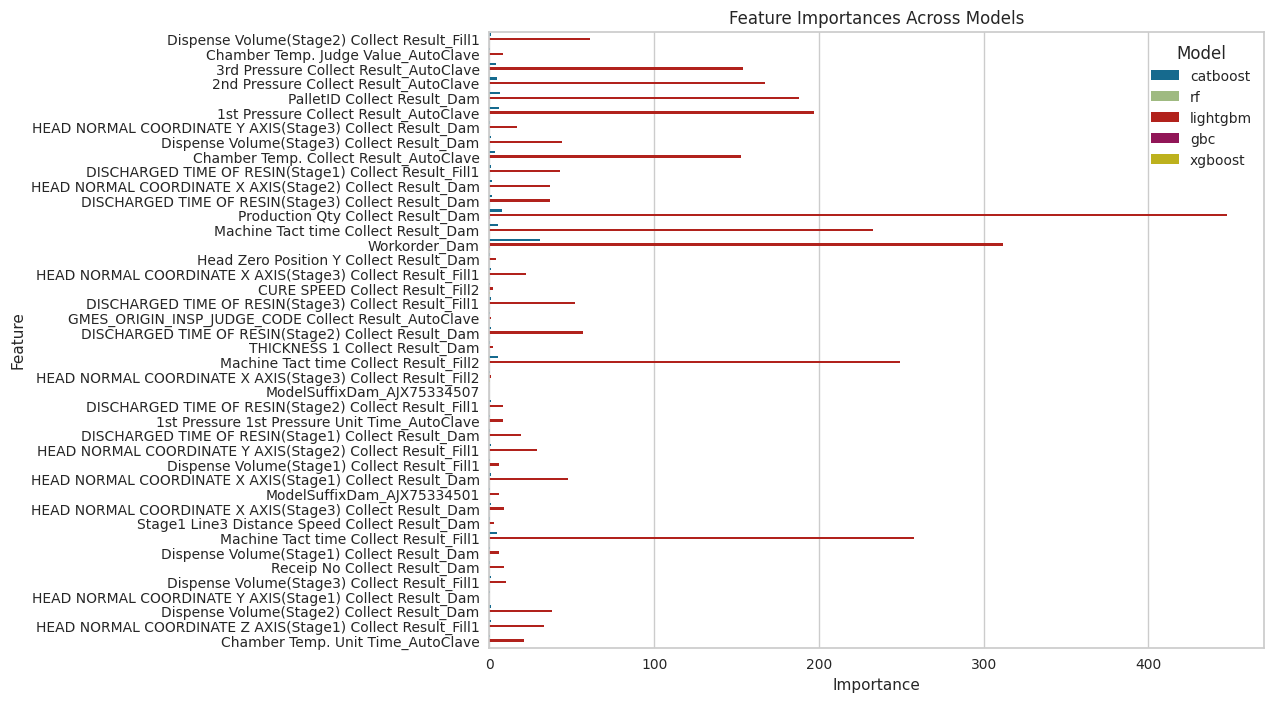

In [101]:
from pycaret.classification import setup, create_model, plot_model
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 준비: X_train에 'target' 열 추가
data = X_train.copy()
data['target'] = y_train

# PyCaret setup: 'target' 열을 사용
clf = setup(data=data, target='target', session_id=123, n_jobs = 4)

# 모델 리스트
models = ['catboost', 'rf', 'lightgbm', 'gbc', 'xgboost']
model_objects = {}

# 각 모델 생성 및 변수 중요도 저장
for model_name in models:
    model = create_model(model_name)
    model_objects[model_name] = model

# 각 모델의 변수 중요도 추출 및 플롯
feature_importances = pd.DataFrame(columns=['Feature', 'Importance', 'Model'])
for model_name, model in model_objects.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = abs(model.coef_[0])
    else:
        continue
    
    # 중요도 데이터 프레임 생성
    features = data.drop('target', axis=1).columns
    model_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances,
        'Model': model_name
    })
    feature_importances = pd.concat([feature_importances, model_importances], axis=0)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x='Importance', y='Feature', hue='Model')
plt.title('Feature Importances Across Models')
plt.show()

In [102]:
# 각 모델별로 상위 20개의 가장 중요한 특성 출력
for model_name in model_objects:
    if 'importances' in locals() or 'importances' in globals():
        # 데이터프레임 필터링
        model_importances = feature_importances[feature_importances['Model'] == model_name]
        
        # 중요도에 따라 내림차순 정렬
        top_features = model_importances.sort_values(by='Importance', ascending=False).head(20)
        
        # 결과 출력
        print(f"Top 5 important features for {model_name}:")
        print(top_features[['Feature', 'Importance']])
        print("\n")  # 결과 간 구분을 위한 줄바꿈
    else:
        print(f"No feature importances available for {model_name}.")

Top 5 important features for catboost:
                                              Feature  Importance
14                                      Workorder_Dam   30.832396
12                  Production Qty Collect Result_Dam    7.948041
4                         PalletID Collect Result_Dam    6.295308
5               1st Pressure Collect Result_AutoClave    6.084293
13               Machine Tact time Collect Result_Dam    5.051187
22             Machine Tact time Collect Result_Fill2    4.996547
34             Machine Tact time Collect Result_Fill1    4.845354
3               2nd Pressure Collect Result_AutoClave    4.719030
2               3rd Pressure Collect Result_AutoClave    3.780610
8              Chamber Temp. Collect Result_AutoClave    3.648495
11  DISCHARGED TIME OF RESIN(Stage3) Collect Resul...    1.694728
10  HEAD NORMAL COORDINATE X AXIS(Stage2) Collect ...    1.531013
20  DISCHARGED TIME OF RESIN(Stage2) Collect Resul...    1.243283
37       Dispense Volume(Stage3) Coll

## valid 예측

In [50]:
from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)


In [112]:
y_pred["prediction_score"]

30019    0.7393
28936    0.9408
17469    0.9146
35438    0.7866
35584    0.9778
          ...  
36266    0.9825
25047    0.9806
17592    0.9014
13813    0.9757
18226    0.9168
Name: prediction_score, Length: 8083, dtype: float64

In [51]:
from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.3f}, F1 Score: {f1:.4f}")

Threshold: 0.500, F1 Score: 0.0000
Threshold: 0.510, F1 Score: 0.0208
Threshold: 0.520, F1 Score: 0.0249
Threshold: 0.530, F1 Score: 0.0412
Threshold: 0.540, F1 Score: 0.0527
Threshold: 0.550, F1 Score: 0.0527
Threshold: 0.560, F1 Score: 0.0526
Threshold: 0.570, F1 Score: 0.0596
Threshold: 0.580, F1 Score: 0.0669
Threshold: 0.590, F1 Score: 0.0744
Threshold: 0.600, F1 Score: 0.0766
Threshold: 0.610, F1 Score: 0.0838
Threshold: 0.620, F1 Score: 0.1004
Threshold: 0.630, F1 Score: 0.1060
Threshold: 0.640, F1 Score: 0.1087
Threshold: 0.650, F1 Score: 0.1237
Threshold: 0.660, F1 Score: 0.1211
Threshold: 0.670, F1 Score: 0.1197
Threshold: 0.680, F1 Score: 0.1180
Threshold: 0.690, F1 Score: 0.1248
Threshold: 0.700, F1 Score: 0.1314
Threshold: 0.710, F1 Score: 0.1323
Threshold: 0.720, F1 Score: 0.1391
Threshold: 0.730, F1 Score: 0.1465
Threshold: 0.740, F1 Score: 0.1501
Threshold: 0.750, F1 Score: 0.1657
Threshold: 0.760, F1 Score: 0.1707
Threshold: 0.770, F1 Score: 0.1697
Threshold: 0.780, F1

In [52]:
# 가장 높은 F1 Score와 해당하는 Threshold 찾기
best_threshold, best_f1_score = max(f1_scores, key=lambda x: x[1])

# 결과 출력
print(f"Best Threshold: {best_threshold:.3f}, Best F1 Score: {best_f1_score:.4f}")

Best Threshold: 0.840, Best F1 Score: 0.1785


### 분류 결과 출력

- valid
- y_valid와 y_valid_pred_encoded 분석

Accuracy: 0.2557393236237965883
F1 Score: 0.2376509911
Confusion Matrix:
[[ 412   58]
 [5972 1660]]


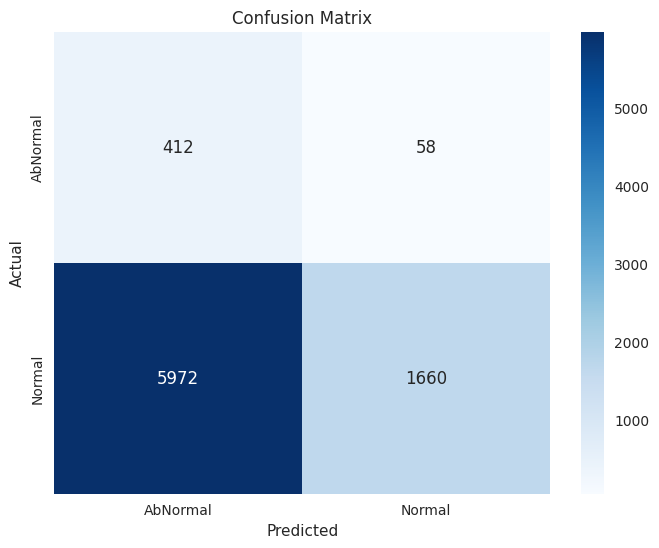

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.06      0.88      0.12       470
      Normal       0.97      0.22      0.36      7632

    accuracy                           0.26      8102
   macro avg       0.52      0.55      0.24      8102
weighted avg       0.91      0.26      0.34      8102

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21366, number of negative: 1316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 22682, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.941980 -> initscore=2.787204
[LightGBM] [Info] Start training from score 2.787204


In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import logging

# 로깅 레벨 설정
logging.getLogger('matplotlib.font_manager').disabled = True

# 이제 폰트 관련 경고 메시지가 출력되지 않습니다.
# 정확도 계산
accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.19f}")

# F1 Score 계산
f1 = f1_score(y_valid, y_valid_pred, average='macro')
print(f"F1 Score: {f1:.10f}")

# 혼동 행렬 계산
cm = confusion_matrix(y_valid, y_valid_pred, labels=['AbNormal', 'Normal'])

# 혼동 행렬 출력
print("Confusion Matrix:")
print(cm)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['AbNormal', 'Normal'], yticklabels=['AbNormal', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 출력
report = classification_report(y_valid, y_valid_pred, target_names=['AbNormal', 'Normal'])
print("Classification Report:")
print(report)

In [24]:
def analyze_class_distribution(y_pred):
    """
    예측된 클래스의 개수와 비율을 분석하고, 평균 및 중간값을 계산하는 함수

    Parameters:
    y_pred (array-like): 예측된 클래스 레이블

    Returns:
    dict: 클래스별 개수, 비율, 비율의 평균 및 중간값
    """
    # 예측된 클래스의 유니크 값과 해당 값들의 개수 계산
    unique_classes, counts = np.unique(y_pred, return_counts=True)

    # 클래스별 개수 및 비율 계산
    total_count = len(y_pred)
    class_counts = dict(zip(unique_classes, counts))
    class_ratios = {cls: count / total_count for cls, count in class_counts.items()}

    # 결과를 딕셔너리로 반환
    results = {
        'class_counts': class_counts,
        'class_ratios': class_ratios
    }

    return results


In [25]:
analysis = analyze_class_distribution(y_valid)

print("클래스별 개수:", analysis['class_counts'])
print("클래스별 비율:", analysis['class_ratios'])

클래스별 개수: {'AbNormal': 470, 'Normal': 7632}
클래스별 비율: {'AbNormal': 0.05801036781041718, 'Normal': 0.9419896321895829}


In [26]:
analysis = analyze_class_distribution(y_valid_pred)

print("클래스별 개수:", analysis['class_counts'])
print("클래스별 비율:", analysis['class_ratios'])

클래스별 개수: {'AbNormal': 8049, 'Normal': 53}
클래스별 비율: {'AbNormal': 0.9934584053320168, 'Normal': 0.006541594667983214}


## test 예측 및 제출

In [27]:
pred = predict_model(blended_model, data = test_df)
y_test_pred = ['Normal' if score >= 0.87 else 'AbNormal' for score in pred['prediction_score']]


# 제출 데이터 읽어오기
df_sub = pd.read_csv("submission.csv")

# 예측값으로 업데이트
df_sub["target"] = y_test_pred

df_sub.to_csv("submission.csv", index=False)

In [28]:
analysis = analyze_class_distribution(y_test_pred)

print("클래스별 개수:", analysis['class_counts'])
print("클래스별 비율:", analysis['class_ratios'])

클래스별 개수: {'AbNormal': 1152, 'Normal': 16209}
클래스별 비율: {'AbNormal': 0.06635562467599793, 'Normal': 0.933644375324002}


### 분류 결과 시각화

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(y_pred):
    # 클래스의 고유 값과 각 값의 개수를 계산
    unique, counts = np.unique(y_pred, return_counts=True)

    # 그래프를 그리기
    plt.figure(figsize=(8, 6))
    plt.bar(unique, counts, color=['pink', 'skyblue'])
    plt.xlabel('Class')
    plt.ylabel('Number of Predictions')
    plt.title('Class Distribution of Predictions')
    plt.show()

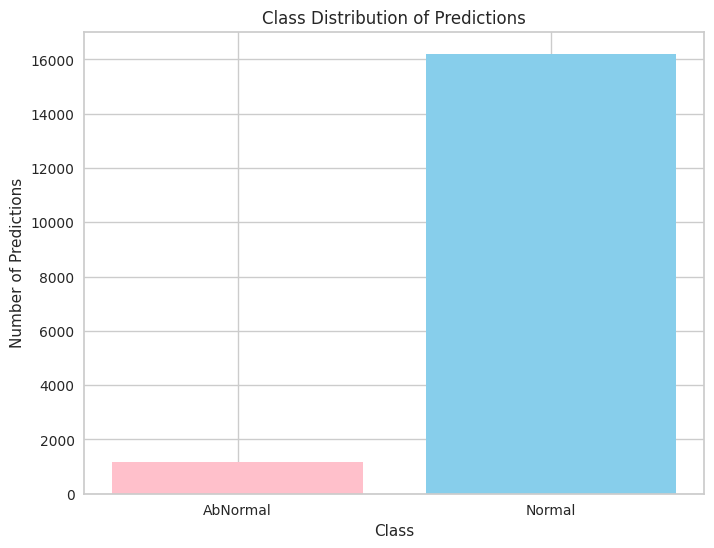

In [30]:
plot_class_distribution(y_test_pred)

In [31]:
unique_indices_list = [64, 562, 1460, 1530, 1892, 2505, 2710, 3457, 3682, 3732, 4928, 4932, 6092, 7001,7287, 7666, 7836, 8253, 8898, 10989, 12439,12585, 12844, 14756, 15180,15406, 15811,15964]

In [32]:
# submission.csv 로드
submission_df = pd.read_csv('submission.csv')

# 불일치하는 행의 target 값을 출력
for idx in unique_indices_list:
    if idx in submission_df.index:
        target_value = submission_df.loc[idx, 'target']
        print(f"Index: {idx}, Target: {target_value}")

Index: 64, Target: Normal
Index: 562, Target: AbNormal
Index: 1460, Target: AbNormal
Index: 1530, Target: AbNormal
Index: 1892, Target: AbNormal
Index: 2505, Target: Normal
Index: 2710, Target: AbNormal
Index: 3457, Target: Normal
Index: 3682, Target: Normal
Index: 3732, Target: Normal
Index: 4928, Target: AbNormal
Index: 4932, Target: AbNormal
Index: 6092, Target: AbNormal
Index: 7001, Target: Normal
Index: 7287, Target: Normal
Index: 7666, Target: AbNormal
Index: 7836, Target: Normal
Index: 8253, Target: AbNormal
Index: 8898, Target: Normal
Index: 10989, Target: AbNormal
Index: 12439, Target: Normal
Index: 12585, Target: AbNormal
Index: 12844, Target: Normal
Index: 14756, Target: AbNormal
Index: 15180, Target: AbNormal
Index: 15406, Target: Normal
Index: 15811, Target: AbNormal
Index: 15964, Target: AbNormal


In [33]:
submission_df = pd.read_csv('submission.csv')

# 불일치하는 행에 대해 target을 'AbNormal'로 설정
for idx in unique_indices_list:
    if idx in submission_df.index:
        submission_df.loc[idx, 'target'] = 'AbNormal'

# 결과 저장
submission_df.to_csv('submission.csv', index=False)

print("Modified submission DataFrame saved.")

Modified submission DataFrame saved.


# 최종 public score

0.18274111675126903
- 와 catboost 넣고, 5개 모델로 늘리고, kfold를 10으로 하니깐 더 높아짐
- 전처리 별로 한 것도 없는데


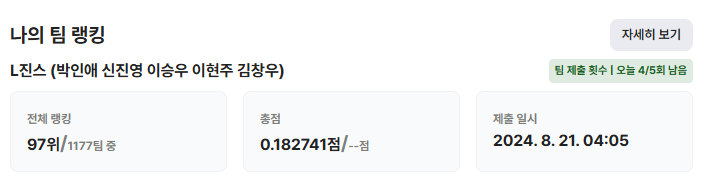

## 최종 public score

0.173554